# RLC Network with Initial Conditions (Example 13)

## Switch from 1 equivalent network to another at t=0

* Conditions prior to $t=0$ lead to initial conditions that must be included

In [5]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://raw.githubusercontent.com/JonHowMIT/Signals_and_Systems/main/basic_material.py
%run basic_material

try:
    import lcapy
except ModuleNotFoundError:
    print("Could not find lcapy - installing")
    !sudo apt install texlive-latex-recommended # takes about 30 sec
    !sudo apt-get install texlive-latex-extra --no-install-recommends # 10 sec
    !sudo apt install imagemagick # 10 sec
    !pip install sympy==1.10.1
    !pip install lcapy # takes 5 sec
    !pip install pdflatex # takes about 5 sec
    print("Will need to restart the Kernel")

from lcapy import Circuit, j, omega, s, exp
from lcapy import R, C, L

from IPython.display import display, Javascript
display(Javascript('document.title = "RLC Network with Initial Conditions";'))

Running Python: 3.8.19
Running Sympy: 1.12.1


<IPython.core.display.Javascript object>

Equivalent Circuit before switch closed at time t=0



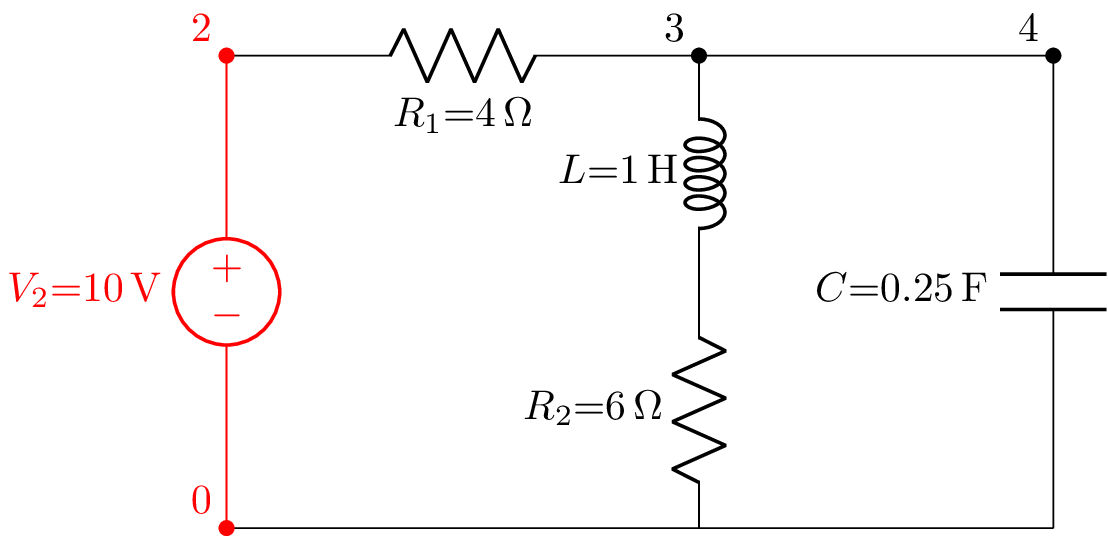



Equivalent Circuit after switch closed at time t=0



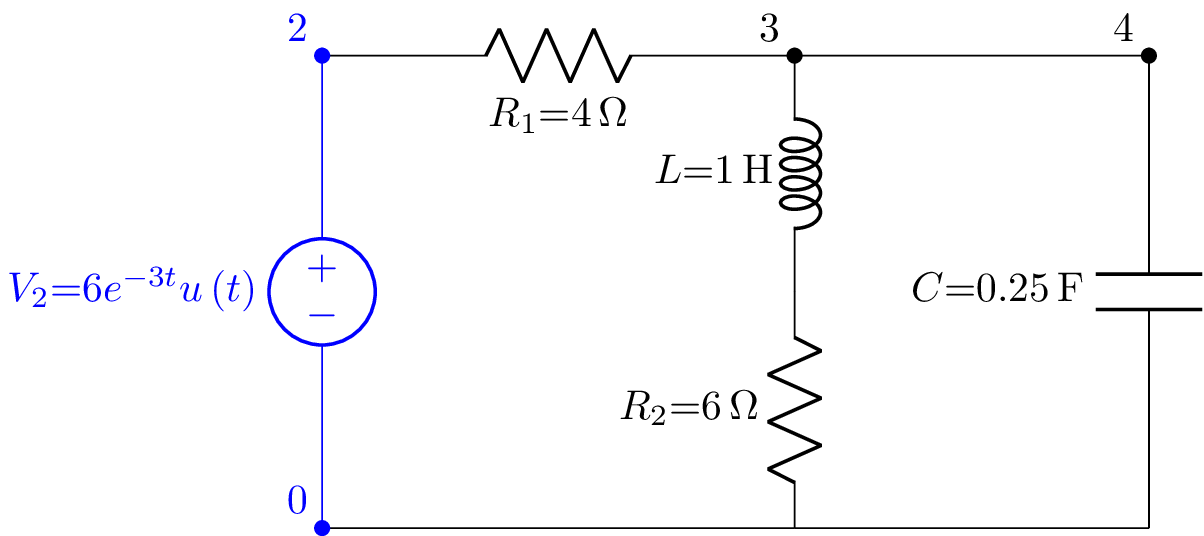

In [6]:
Vin = 10
CC = 0.25
LL = 1

# first network with a dc input t < 0
cct8_0 = Circuit("""
V2 2 0 dc 10; down, color=red
R1 2 3 4 ; right=2
L 3 1_3 L ; down=1
R2 1_3 0_3 6 ; down=1
W 3 4; right=1.5
C 4 0_4 C; down=1 
W 0 0_3; right
W 0_3 0_4; right
""")

# second network with a ac input t >= 0 
cct8_1 = Circuit("""
V2 2 0 {6*exp(-3*t)*Heaviside(t)}; down, color=blue
R1 2 3 4 ; right=2
L 3 1_3 L ; down=1
R2 1_3 0_3 6 ; down=1
W 3 4; right=1.5
C 4 0_4 C; down=1 
W 0 0_3; right
W 0_3 0_4; right
""")

cct8_0a = cct8_0.subs({'C':CC, 'L':LL}) # negative time circuit
cct8_1a = cct8_1.subs({'C':CC, 'L':LL}) # positive time circuit

# switch networks at time 0
cct8_1a = cct8_1a.initialize(cct8_0a, 0) 

print('Equivalent Circuit before switch closed at time t=0\n')
cct8_0a.draw()
print('\n\nEquivalent Circuit after switch closed at time t=0\n')
cct8_1a.draw()

In [7]:
tt = np.linspace(0, 10, 100)
tneg = np.linspace(-5, 0, 100)
vc_neg = cct8_0a.C.v.evaluate(tneg)
vc_pos = cct8_1a.C.v.evaluate(tt)
ilneg = cct8_0a.L.i.evaluate(tneg)
il = cct8_1a.L.i.evaluate(tt)

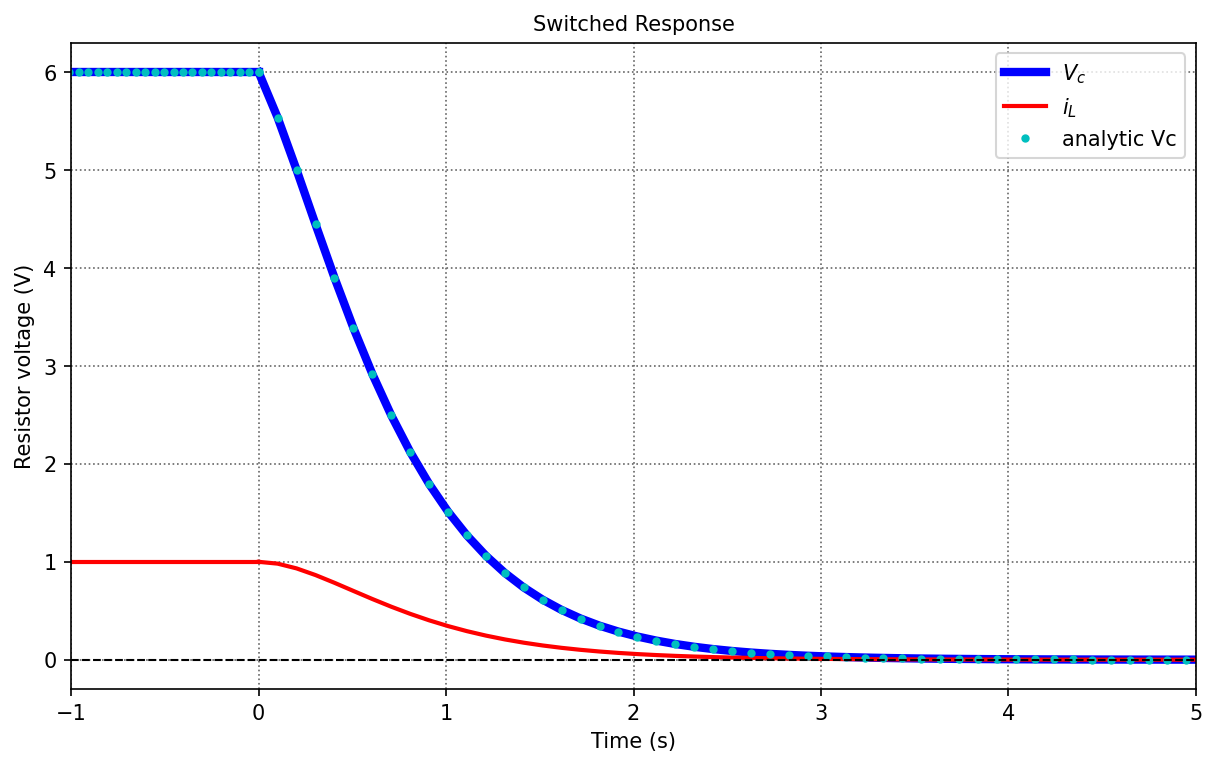

In [8]:
fig = figure(figsize=(8, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Switched Response')
ax.plot(tt, vc_pos, 'b-', linewidth=4, label='$V_c$')
ax.plot(tneg, vc_neg, 'b-', linewidth=4)
ax.plot(tneg, ilneg, linewidth=2, color='red', label='$i_L$')
ax.plot(tt, il, linewidth=2, color='red')
ax.plot(tt, 44/3*np.exp(-2*tt)+np.exp(-5*tt)/3-9*np.exp(-3*tt), 'c.', label='analytic Vc')
ax.plot(tneg, tneg*0+6, 'c.')
ax.set_xlabel('Time (s)')
ax.set_xlim(-1,5)
ax.set_ylabel('Resistor voltage (V)');
nicegrid(ax)
plt.legend()
plt.show()

## Derive expression for the current 

In [27]:
from sympy.integrals.transforms import laplace_transform 
from sympy.integrals.transforms import inverse_laplace_transform 
import sympy as sp 
import numpy as np 
from sympy.abc import a, t, x, s, X, g, G 
from sympy import DiracDelta
init_printing(use_unicode=True)

svc, svs, sil = symbols('svc svs sil', cls = Function) 
svs = 6*sympy.exp(-3*t)*Heaviside(t) 

In [28]:
# capacitor voltage as determined in the notes
svc = (44/3*sympy.exp(-2*t) + 1/3*sympy.exp(-5*t) -9*sympy.exp(-3*t))*Heaviside(t) + 6*(1-Heaviside(t))

In [41]:
# find derivative of the capac voltage and confirm correct value
svcdot = svc.diff(t)
svcdot0_pos = svcdot.subs(t,0+np.finfo(float).eps)
print(f"The value of ths should be -4. {svcdot0_pos= : 4.3f}") 

The value of ths should be -4. svcdot0_pos= -4.000


In [30]:
# equations from notes
# first term only valid for pos time - added second term for negative time
sil = (svs/4-svcdot/4-svc/4)*Heaviside(t) + 1*(1-Heaviside(t))

In [31]:
# find initial i to confirm that it is 1, as required
sil_pos = sil.subs(t,0+np.finfo(float).eps) 
print(f"The value of ths should be 1. {sil_pos= : 4.3f}")

The value of ths should be 1. sil_pos=  1.000


In [39]:
# convert sympy output to matplotlib format
t_all = np.linspace(-1, 5, 1000)
IL = np.zeros(len(t_all))
for n,t_test in enumerate(t_all):
    IL[n] = sil.subs(t,t_test)

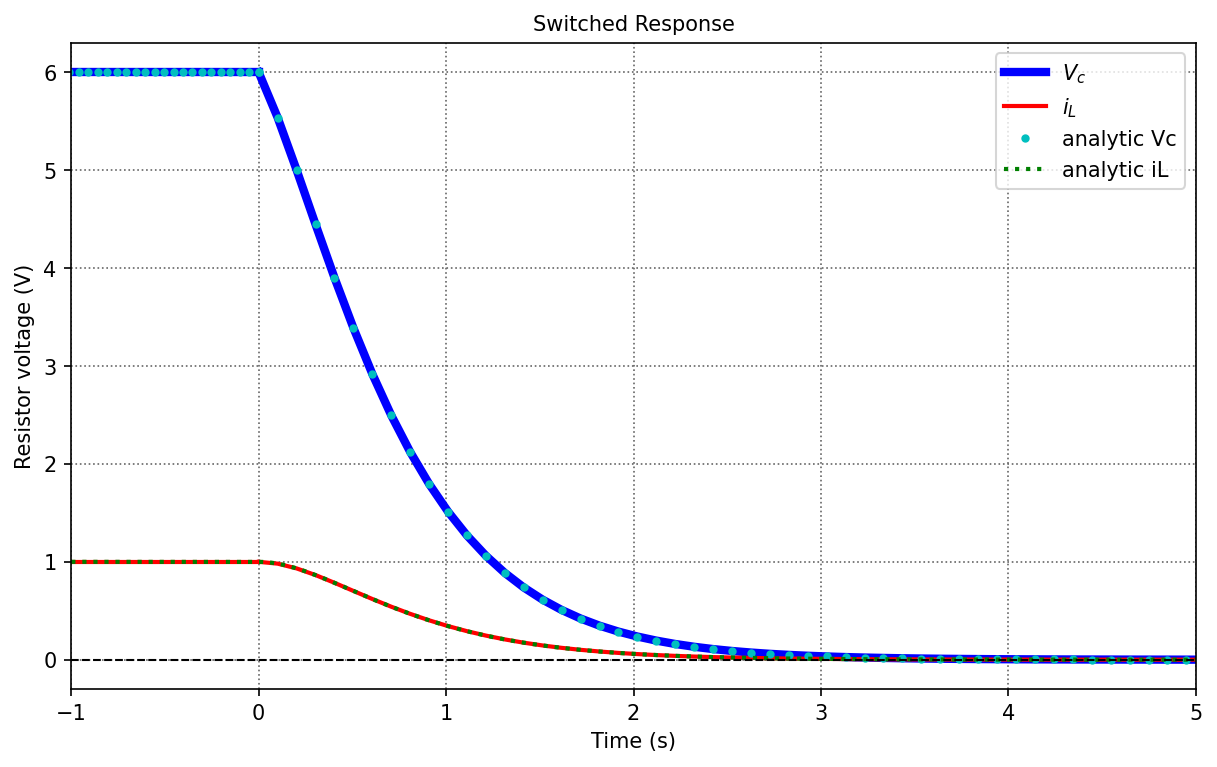

In [38]:
fig = figure(figsize=(8, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Switched Response')
ax.plot(tt, vc_pos, 'b-', linewidth=4, label='$V_c$')
ax.plot(tneg, vc_neg, 'b-', linewidth=4)
ax.plot(tneg, ilneg, linewidth=2, color='red', label='$i_L$')
ax.plot(tt, il, linewidth=2, color='red')
ax.plot(tt, 44/3*np.exp(-2*tt)+np.exp(-5*tt)/3-9*np.exp(-3*tt), 'c.', label='analytic Vc')
ax.plot(tneg, tneg*0+6, 'c.')
plt.plot(t_all,IL, 'g:', label='analytic iL')

ax.set_xlabel('Time (s)')
ax.set_xlim(-1,5)
ax.set_ylabel('Resistor voltage (V)');
nicegrid(ax)
plt.legend()
plt.show()